In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

# Configuration
DATA_PATH = 'CMAPSSData/'  
DATASET_NUM = 1            
MODEL_TYPE = 'lstm'        # 'lstm' or 'gru'
TRAIN_PERCENT = 0.85       # Percentage of initial cycles for training
SEQUENCE_LENGTH = 10       
THRESHOLD_MULTIPLIER = 2.5 # Multiplier for threshold (μ + nσ)

# Load model
model = keras.models.load_model(f'models/pmodel_{MODEL_TYPE}_{DATASET_NUM}.keras')

# Load scaler
with open(f'models/scaler_{DATASET_NUM}.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load train and test data
test_data = pd.read_csv(f'processed_data/test_data_{DATASET_NUM}.csv')
train_data = pd.read_csv(f'processed_data/train_data_{DATASET_NUM}.csv')

In [14]:
# Prepare sequences for LSTM/GRU
def create_sequences(data, sequence_length=SEQUENCE_LENGTH):
    """Creates temporal sequences for the model"""
    features = [f'sensor{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
    sequences = []
    engine_ids = data['id'].unique()
    
    for engine_id in engine_ids:
        engine_data = data[data['id'] == engine_id]
        engine_values = engine_data[features].values
        for i in range(len(engine_values) - sequence_length + 1):
            sequences.append(engine_values[i:i + sequence_length])
    
    return np.array(sequences)

def process_data(file):
    data = pd.read_csv(file, sep=' ', header=None)
    data.drop(data.columns[[26, 27]], axis=1, inplace=True)
    data.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
    return data

In [15]:
sensor_cols = [f'sensor{i}' for i in range(1, 22)]
settings_cols = ['setting1', 'setting2', 'setting3']

train_scaled = train_data.copy()

train_scaled[sensor_cols + settings_cols] = scaler.fit_transform(train_data[sensor_cols + settings_cols])


train_ids = train_scaled['id'].unique()

min_mse_list = []
max_mse_list = []

for engine_id in train_ids:
    # Generate sequence for each engine
    engine_data = train_scaled[train_scaled['id'] == engine_id]
    X_train = create_sequences(engine_data)

    # Prediction and MSE calculation for each engine
    X_train_pred = model.predict(X_train, verbose=0)
    mse = np.mean(np.power(X_train - X_train_pred, 2), axis=(1,2))

    min_mse_list.append(np.min(mse))
    max_mse_list.append(np.max(mse))

min_mse = np.mean(min_mse_list)
max_mse = np.mean(max_mse_list)



In [16]:
def compute_health_indicator(mse, min_mse=min_mse, max_mse=max_mse):
    """
    Converts reconstruction error into a normalized health indicator (1=healthy, 0=failure).
    """
    if min_mse is None:
        min_mse = np.min(mse)
    if max_mse is None:
        max_mse = np.max(mse)
    health = 1 - (mse - min_mse) / (max_mse - min_mse + 1e-8)
    health = np.clip(health, 0, 1)
    return health

4/4 [==============================] - 0s 28ms/step


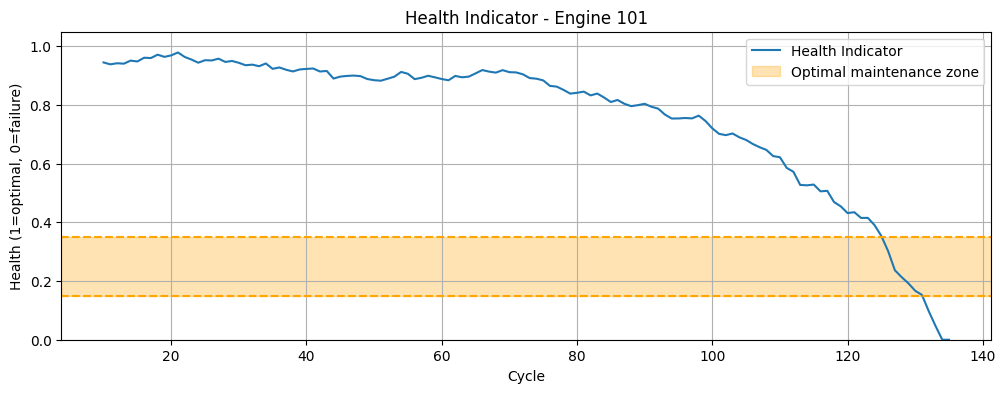

In [20]:
# Select the engine ID you want to analyze
# Test Engines with low RUL left: [31, 34, 68, 76, 81, 82]
# Test Engines with zero RUL left: [101, 102, 103, 104, 105, 106, 107, 108, 109, 110]

engine_id = 101  # Change this value for the desired ID

# Filter data for that engine
df_engine = test_data[test_data['id'] == engine_id].copy()
features = [f'sensor{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']

# Get cycles (adjusted for sequence length)
cycles = df_engine['cycle'].values[SEQUENCE_LENGTH-1:]

# Prepare sequences for the model
sequences = []
engine_values = df_engine[features].values
for i in range(len(engine_values) - SEQUENCE_LENGTH + 1):
    sequences.append(engine_values[i:i + SEQUENCE_LENGTH])
sequences = np.array(sequences)

# Calculate model predictions
X_pred = model.predict(sequences)

# Calculate reconstruction error (MSE) per cycle
mse = np.mean(np.power(sequences - X_pred, 2), axis=(1,2))

# Calculate health indicator
health = compute_health_indicator(mse)

# Plot health indicator
plt.figure(figsize=(12,4))
plt.plot(cycles, health, label='Health Indicator')

# Add threshold band for optimal maintenance
plt.axhspan(0.15, 0.35, color='orange', alpha=0.3, label='Optimal maintenance zone')
plt.axhline(y=0.15, color='orange', linestyle='--')
plt.axhline(y=0.35, color='orange', linestyle='--')


plt.xlabel('Cycle')
plt.ylabel('Health (1=optimal, 0=failure)')
plt.title(f'Health Indicator - Engine {engine_id}')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()